# **Data Preprocessing**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
import scipy.io
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [2]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cpu


In [4]:
# Hyperparameters
num_classes = 120
learning_rate = 0.001
batch_size = 32
num_epochs = 15

In [5]:
# Custom Dataset Class
class StanfordDogsDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform

        # Load .mat files containing the breed annotations
        self.labels = self.load_annotations()

        # List all dog breeds in the dataset
        self.breeds = sorted(os.listdir(images_dir))

        self.image_paths = []
        self.image_labels = []

        # Collect image paths and corresponding breed labels
        for breed in self.breeds:
            breed_path = os.path.join(self.images_dir, breed)
            breed_images = os.listdir(breed_path)
            for img_name in breed_images:
                self.image_paths.append(os.path.join(breed_path, img_name))
                self.image_labels.append(self.breeds.index(breed))

    def load_annotations(self):
        # Initialize a dictionary to store breed-to-annotation mapping
        breed_annotations = {}

        # Loop through each breed folder in the annotations folder
        for breed_folder in os.listdir(self.annotations_dir):
            breed_path = os.path.join(self.annotations_dir, breed_folder)

            if os.path.isdir(breed_path):
                # Load .mat file containing annotations for this breed
                annotation_file = os.path.join(breed_path, 'annotation.mat')
                if os.path.exists(annotation_file):
                    # Load the .mat file (scipy.io.loadmat)
                    mat_data = scipy.io.loadmat(annotation_file)

                    # Assuming annotations are stored in a variable 'annotations' inside the .mat file
                    annotations = mat_data.get('annotations', None)

                    if annotations is not None:
                        breed_annotations[breed_folder] = annotations[0, :]

        return breed_annotations

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get the image path and label corresponding to the index
        image_path = self.image_paths[idx]
        label = self.image_labels[idx]

        # Load the image
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Image Transformation and Augmentation

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(30),      # Random rotation between -30 to 30 degrees
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # Random affine transformation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),  # Random perspective distortion
    transforms.ToTensor(),              # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Validation/Testing Transformations
test_transforms = transforms.Compose([
    transforms.Resize(256),           # Resize the image to 256px
    transforms.CenterCrop(224),       # Center crop to 224px
    transforms.ToTensor(),            # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [7]:
# Loading dataset

images_dir = '/content/drive/MyDrive/Deep_Learning_Projects/DogBreedClassifier/data/Stanford_Dogs_Dataset/images/Images'  # Path to the images folder
annotations_dir = '/content/drive/MyDrive/Deep_Learning_Projects/DogBreedClassifier/data/Stanford_Dogs_Dataset/annotations/Annotation'  # Path to the annotations folder

dataset = StanfordDogsDataset(images_dir, annotations_dir)

# Split dataset into training and testing sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Apply transformations to train and test subsets separately
train_dataset.dataset.transform = train_transforms  # Apply train transforms to the training set
test_dataset.dataset.transform = test_transforms    # Apply test transforms to the testing set

# Define DataLoader for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

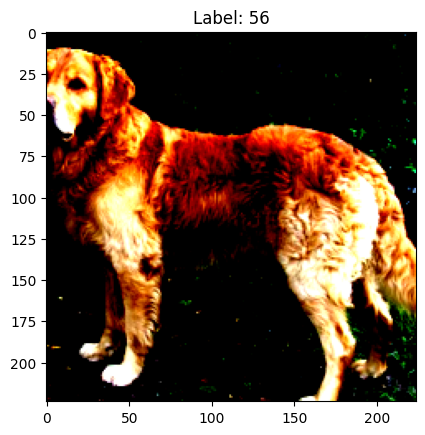

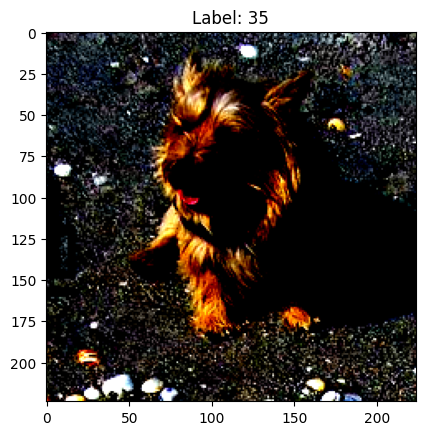

In [ ]:
# Check if data is loaded properly in train_loader
images, labels = next(iter(train_loader))
plt.imshow(images[0].permute(1, 2, 0))  # Convert from Tensor format (C, H, W) to (H, W, C)
plt.title(f'Label: {labels[0]}')
plt.show()

# Check if data is loaded properly in test_loader
images, labels = next(iter(test_loader))
plt.imshow(images[0].permute(1, 2, 0))  # Convert from Tensor format (C, H, W) to (H, W, C)
plt.title(f'Label: {labels[0]}')
plt.show()


# **Model Training**

In [8]:
# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Modify the fully connected layers (classifier)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Freeze convolutional layers (feature extractor)
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU if available
model.to(device)

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 84.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (fine-tuning only the final fully connected layers)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate, weight_decay=1e-4)

# Scheduler to reduce learning rate when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-9-9fad3241607f>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [10]:
# checkpoint directory
checkpoint_dir = "/content/drive/MyDrive/model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Checkpoint Save
def save_checkpoint(model, optimizer, scheduler, epoch, loss, filename):
    """ Save model weights, optimizer state, and scheduler state """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at {filename}")

# Checkpoint Load
def load_checkpoint(model, optimizer, scheduler, filename):
    """ Load the checkpoint and resume training """
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {filename}")
    return model, optimizer, scheduler, epoch, loss


In [11]:
# Loading the Last Checkpoint
model, optimizer, scheduler, start_epoch, last_loss = load_checkpoint(model, optimizer, scheduler, '/content/drive/MyDrive/Deep_Learning_Projects/DogBreedClassifier/deployment/model_checkpoints/checkpoint_epoch_4.pth')

<ipython-input-10-09a4096b46df>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from /content/drive/MyDrive/Deep_Learning_Projects/DogBreedClassifier/deployment/model_checkpoints/checkpoint_epoch_4.pth


In [12]:
start_epoch = start_epoch + 1
print(start_epoch)

4


In [ ]:
# Train Network
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0

    # Initialize tqdm progress bar for the current epoch
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for batch_idx, (X_batch, y_batch) in enumerate(loop):

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass with automatic mixed precision
        with torch.cuda.amp.autocast():
          y_pred = model(X_batch)
          loss = criterion(y_pred, y_batch)

       # Backward pass and optimizer step with scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Update tqdm description with running loss
        loop.set_postfix(loss=running_loss / (batch_idx + 1))

    # calculate the average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Apply ReduceLROnPlateau scheduler after each epoch, passing the average loss
    scheduler.step(epoch_loss)

    # Save checkpoint
    checkpoint_filename = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
    save_checkpoint(model, optimizer, scheduler, epoch, epoch_loss, checkpoint_filename)


In [ ]:
# Define test loop function
def test_model(model, loader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    all_labels = []
    all_preds = []

    # Initialize tqdm progress bar for the test phase
    loop = tqdm(loader, desc="Testing", leave=False)

    with torch.no_grad():  # Disable gradient calculation for testing
        for batch_idx, (X_batch, y_batch) in enumerate(loop):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)

            # Accumulate test loss
            running_loss += loss.item()

            # Store predictions and labels for metric calculation
            _, predicted = torch.max(y_pred, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

            # Update tqdm progress bar with running loss
            loop.set_postfix(loss=running_loss / (batch_idx + 1))

    # Calculate average test loss
    avg_loss = running_loss / len(loader)
    print(f"Average Test Loss: {avg_loss:.4f}")

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    class_report = classification_report(all_labels, all_preds, target_names=loader.dataset.classes)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("\nClassification Report:\n", class_report)

    return avg_loss, accuracy, f1, class_report


In [ ]:
test_model(model=model, loader=train_loader, criterion=criterion)

In [ ]:
test_model(model=model, loader=test_loader, criterion=criterion)

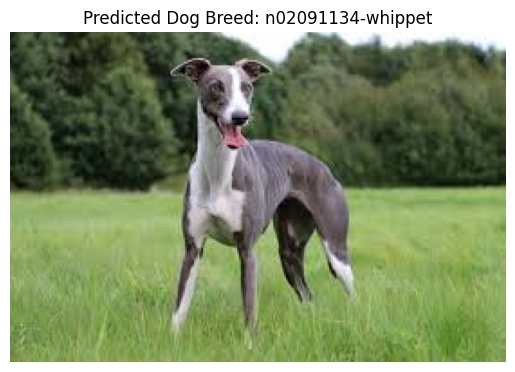

In [ ]:
# Making Predictions

# Load and preprocess the image
image = Image.open('/content/dog2.jpeg').convert('RGB')
image = test_transforms(image).unsqueeze(0)  # Add batch dimension (1, 3, 224, 224)

# Move image tensor to the same device as the model (GPU/CPU)
image = image.to(device)

# Set the model to evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    outputs = model(image)

# Get predicted class (index of the max value)
_, predicted_class = torch.max(outputs, 1)

predicted_class = predicted_class.item()

# Path to your images directory
images_dir = r'/content/drive/MyDrive/Deep_Learning_Projects/DogBreedClassifier/data/Stanford_Dogs_Dataset/images/Images'

# Get all folder names (dog breeds) in the directory
breed_names = sorted(os.listdir(images_dir))

predicted_dog_breed = breed_names[predicted_class]

plt.imshow(Image.open('/content/dog2.jpeg'))
plt.title(f'Predicted Dog Breed: {predicted_dog_breed}')
plt.axis('off')
plt.show()

# **Model Deployment**

In [16]:
from flask import Flask, request, jsonify, render_template_string
from pyngrok import ngrok
import torch
from PIL import Image
import os
from torchvision import transforms
import base64
from io import BytesIO

app = Flask(__name__)

# Load the mode
IMAGES_DIR = r'/content/drive/MyDrive/Deep_Learning_Projects/DogBreedClassifier/data/Stanford_Dogs_Dataset/images/Images'

# Load model
model.eval()

# Get breed names from directories
breed_names = sorted(os.listdir(IMAGES_DIR))

# Define image transformations
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

@app.route("/", methods=["GET", "POST"])
def index():
    if request.method == "POST":
        # Check if an image was uploaded
        if "file" not in request.files:
            return "No file uploaded", 400
        file = request.files["file"]

        if file.filename == "":
            return "No file selected", 400

        # Process the uploaded image
        image = Image.open(file).convert('RGB')
        image_tensor = test_transforms(image).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            outputs = model(image_tensor)
        _, predicted_class = torch.max(outputs, 1)
        predicted_class = predicted_class.item()
        predicted_breed = breed_names[predicted_class]

        # Convert image to base64 for HTML rendering
        buffer = BytesIO()
        image.save(buffer, format="JPEG")
        buffer.seek(0)
        image_data = base64.b64encode(buffer.read()).decode("utf-8")

        # Render result
        return render_template_string("""
            <!DOCTYPE html>
            <html>
            <head>
                <title>Prediction Result</title>
            </head>
            <body>
                <h1>Prediction Result</h1>
                <img src="data:image/jpeg;base64,{{ image_data }}" alt="Dog Image" style="max-width: 100%; height: auto;">
                <h2>Predicted Breed: {{ breed }}</h2>
                <a href="/">Upload Another Image</a>
            </body>
            </html>
        """, breed=predicted_breed, image_data=image_data)

    # HTML form for image upload
    return """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Dog Breed Prediction</title>
        </head>
        <body>
            <h1>Upload a Dog Image</h1>
            <form action="/" method="post" enctype="multipart/form-data">
                <input type="file" name="file" accept="image/*" required>
                <button type="submit">Predict</button>
            </form>
        </body>
        </html>
    """

public_url = ngrok.connect(5000)
print("ngrok tunnel URL:", public_url)

if __name__ == "__main__":
  app.run()

ngrok tunnel URL: NgrokTunnel: "https://02c3-34-80-8-147.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
